Posture detection example (in adaption) potential usage for automatic mask generation

In [1]:
import torch
import torchvision
from torchvision.transforms import transforms as transforms
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import seaborn_image as isns
from PIL import Image
from typing import Dict, Tuple

In [2]:
image_paths = [ "img/0001.jpg", "img/0108.jpg", "img/0115.jpg", "img/0150.jpg"]
images_with_positions = []

In [3]:
# pairs of edges for 17 of the keypoints detected
edges = [
    (0, 1), (0, 2), (2, 4), (1, 3), (6, 8), (8, 10),
    (5, 7), (7, 9), (5, 11), (11, 13), (13, 15), (6, 12),
    (12, 14), (14, 16), (5, 6)
]

In [4]:
def draw_keypoints(model_output: Dict[str,torch.Tensor], img: np.array) -> np.array:
    for i in range(len(model_output[0]['keypoints'])):
        keypoints = model_output[0]['keypoints'][i].cpu().detach().numpy()
        
        # proceed to draw the lines if the confidence score is above 0.9
        if model_output[0]['scores'][i] > 0.9:
            keypoints = keypoints[:, :].reshape(-1, 3)
            
            for p in range(keypoints.shape[0]):
                # draw the keypoints
                cv2.circle(img, (int(keypoints[p, 0]), int(keypoints[p, 1])), 
                            3, (0, 0, 255), thickness=-1, lineType=cv2.FILLED)
                
            for ie, e in enumerate(edges):
                # different colors for the edges
                rgb = matplotlib.colors.hsv_to_rgb([
                    ie/float(len(edges)), 1.0, 1.0
                ])
                rgb = rgb*255

                # join the keypoint pairs to draw the skeletal structure
                cv2.line(img, 
                         ( int(keypoints[e, 0][0]), int(keypoints[e, 1][0]) ) ,
                         ( int(keypoints[e, 0][1]), int(keypoints[e, 1][1])) ,
                         tuple(rgb), 2, lineType=cv2.LINE_AA)

        else:
            continue
    return img

In [5]:
#See https://stackoverflow.com/questions/58236138/pil-and-python-static-typing
#def train_model(img: Image) -> Tuple[Dict[str,torch.Tensor], Image]:
def train_model(img: Image) -> np.array:
    
    # transform to convert the image to tensor
    transform = transforms.Compose([transforms.ToTensor()])
    
    # initialize the model
    model = torchvision.models.detection.keypointrcnn_resnet50_fpn(pretrained=True,
                                                                   num_keypoints=17)
    # set the computation device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # load the model and set to eval mode
    model.to(device).eval()
    
    orig_numpy = np.array(img, dtype=np.float32)
    
    img = transform(img)
    
    # add a batch dimension
    img = img.unsqueeze(0).to(device)

    with torch.no_grad():
        model_output = model(img)

    output_image = draw_keypoints(model_output, orig_numpy)
    
    return output_image
    
    

/Users/nea/miniconda3/envs/work-env/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1639180852547/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


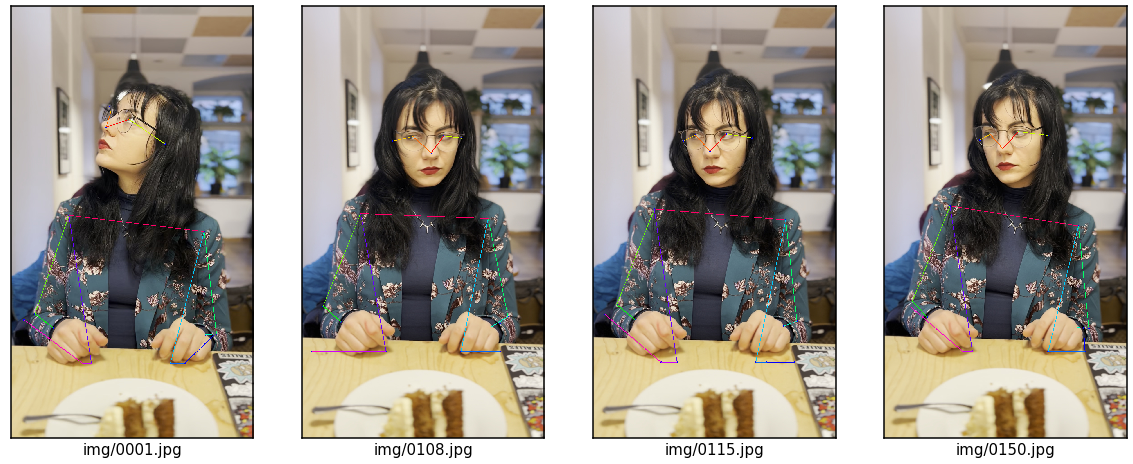

In [6]:
xlen = len(image_paths)
fig, axes = plt.subplots(1, xlen)
fig.set_size_inches(20,10)
for ax, img_path in zip(axes, image_paths):
    img = Image.open(img_path)
    #gosh than feels ugly ^^
    output_img = train_model(img)
    isns.imgplot(output_img.astype('uint8'), ax=ax, cbar=False)
    ax.invert_yaxis()
    ax.set_xlabel(img_path)